In [179]:
import os
import random
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from joblib import dump, load
from tqdm import tqdm
from wandb.sklearn import plot_learning_curve
from sklearn.model_selection import GridSearchCV
import time

MODEL_OUTPUT_PATH = "../src/models/"
SCALER_OUTPUT_PATH = "../src/scaler/"

In [180]:
columns = ['Invested Amount', 'Successful Attacks', 'Failed Attacks', 'Business Value', 'Number of Employees', 'Employee Training', 'Known Vulnerabilities', 'External Advisor', 'Risk']
features = columns[:-1]
LEVELS = ['LOW', 'MEDIUM', 'HIGH']
ADVISOR = ['NO', 'YES']
prediction_result_mapping = {0: 'LOW', 1: 'MEDIUM', 2: 'HIGH'}

In [181]:
def generate_data(nr_entries = 1000, min_empl = 30, max_empl = 10000, min_nr_attacks = 0, nr_attacks = 50, 
                  avg_business_value = 5000000, std_business_value = 50000, max_invested_perc = 0.3, max_nr_vulnerabilities = 10):
    df = pd.DataFrame(columns=columns)
    for i in tqdm(range(0, nr_entries)):
        nr_employees = random.randint(min_empl, max_empl)
        employees_training = random.choice(LEVELS)
        
        failed_attack = random.randrange(nr_attacks)
        succ_attack = random.randrange(nr_attacks)
        
        business_value = int(numpy.random.normal(loc=avg_business_value, scale=std_business_value))
        invested_perc = random.uniform(0, max_invested_perc)
        invested_amount = int(invested_perc * business_value)
        
        known_vulnerabilities = random.randrange(max_nr_vulnerabilities)
        external_adv = random.choice(ADVISOR)

        # Risk is computed based on the other parameters and is then categorized using 'get_categorized_risk'
        computed_risk = invested_perc - (succ_attack / nr_attacks) + (nr_employees / max_empl) * LEVELS.index(employees_training) - (known_vulnerabilities / max_nr_vulnerabilities) + ADVISOR.index(external_adv)
                
        df.loc[i] = [invested_amount, succ_attack, failed_attack, business_value, nr_employees, employees_training, known_vulnerabilities, external_adv, get_categorized_risk(computed_risk)]
    return df

def get_categorized_risk(weighted_risk, upper_boundary = 1.0, lower_boundary = 0.0):
  if weighted_risk >= upper_boundary:
      return "LOW"
  elif weighted_risk >= lower_boundary and weighted_risk < upper_boundary:
      return "MEDIUM"
  else:
      return "HIGH"

In [182]:
data = generate_data(nr_entries = 50000)

100%|██████████| 50000/50000 [04:02<00:00, 205.76it/s]


In [183]:
start = time.time()

levels_mapping = { 'LOW': 0, 'MEDIUM': 1, 'HIGH': 2 }
advisor_mapping = { 'NO': 0, 'YES': 1 }

data = data.replace({'Employee Training': levels_mapping, 'Risk': levels_mapping, 'External Advisor': advisor_mapping})

stop = time.time()
print(f"Categorization time: {stop - start}s")

Categorization time: 0.052388906478881836s


In [184]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Used for the scikit models
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, test_size=0.2)

scaler = MinMaxScaler()
scaler.fit(X_train)

# Normalized Splitted X Data
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

# DECISION TREE

In [185]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score

# Define the parameter ranges that should be tested on the model
dtree_params = {
    'criterion': ["gini", "entropy"],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

# Instanciate the Grid for parameter tuning
dtree_grid = GridSearchCV(DecisionTreeClassifier(), dtree_params, cv=5, scoring='accuracy', n_jobs=-1)

start = time.time()
dtree = dtree_grid.fit(X_train, y_train)
stop = time.time()
print(f"Decision Tree Cross-Validation & Training time: {stop - start}s")

Decision Tree Cross-Validation & Training time: 161.44733095169067s


In [186]:
print(dtree.best_estimator_)
print(dtree.best_params_)
print('Best Accuracy: {0:.2%}'.format(dtree.best_score_))

DecisionTreeClassifier(max_depth=9, min_samples_leaf=8, min_samples_split=9)
{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 8, 'min_samples_split': 9}
Best Accuracy: 92.21%


In [187]:
test = DecisionTreeClassifier(max_depth=9, min_samples_leaf=4, min_samples_split=7)

start = time.time()
test = test.fit(X_train, y_train)
stop = time.time()
print(f"Decision Tree Training time: {stop - start}s")

Decision Tree Training time: 0.1652541160583496s


In [188]:
accuracy = dtree.score(X_test, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 92.39%


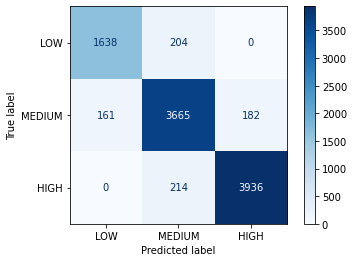

In [189]:
f = plot_confusion_matrix(dtree, X_test, y_test, cmap='Blues', display_labels = LEVELS)  
plt.show()
f.figure_.savefig("dtree_confusion.pdf", bbox_inches='tight')

In [190]:
print(classification_report(y_test, dtree.predict(X_test), target_names=LEVELS))

              precision    recall  f1-score   support

         LOW       0.91      0.89      0.90      1842
      MEDIUM       0.90      0.91      0.91      4008
        HIGH       0.96      0.95      0.95      4150

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



# Support Vector Machine (SVM)

In [191]:
from sklearn.svm import LinearSVC, SVC 

# Define the parameter ranges that should be tested on the model
svm_params = {
    'kernel': ["poly", "rbf", "sigmoid"],
    'gamma': ["scale", "auto"]
}

# Instanciate the Grid for parameter tuning
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)

start = time.time()
svm = svm_grid.fit(X_train_normalized, y_train)

stop = time.time()
print(f"Support Vector Machine Cross-Validation & Training time: {stop - start}s")

/usr/local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Support Vector Machine Cross-Validation & Training time: 161.30179691314697s


In [192]:
print(svm.best_estimator_)
print(svm.best_params_)
print('Best Accuracy: {0:.2%}'.format(svm.best_score_))

SVC()
{'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 98.80%


In [193]:
test = SVC()

start = time.time()
test = test.fit(X_train_normalized, y_train)
stop = time.time()
print(f"SVM Training time: {stop - start}s")

SVM Training time: 6.557694911956787s


In [194]:
accuracy = svm.score(X_test_normalized, y_test) 

print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 98.95%


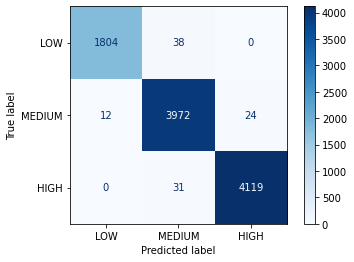

In [195]:
f = plot_confusion_matrix(svm, X_test_normalized, y_test, cmap='Blues', display_labels = LEVELS)  
plt.show()
f.figure_.savefig("svm_confusion.pdf", bbox_inches='tight')

In [196]:
print(classification_report(y_test, svm.predict(X_test_normalized), target_names=LEVELS))

              precision    recall  f1-score   support

         LOW       0.99      0.98      0.99      1842
      MEDIUM       0.98      0.99      0.99      4008
        HIGH       0.99      0.99      0.99      4150

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# K-nearest Neighbours Classifier

In [197]:
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter ranges that should be tested on the model
knn_params = {
    'n_neighbors': range(1, 30),
    'weights': ['uniform', 'distance']
}

# Instanciate the Grid for parameter tuning
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', n_jobs=-1)

start = time.time()
knn = knn_grid.fit(X_train_normalized, y_train)
stop = time.time()
print(f"KNN Cross-Validation & Training time: {stop - start}s")

KNN Cross-Validation & Training time: 41.46168088912964s


In [198]:
print(knn.best_estimator_)
print(knn.best_params_)
print('Best Accuracy: {0:.2%}'.format(knn.best_score_))

KNeighborsClassifier(n_neighbors=22, weights='distance')
{'n_neighbors': 22, 'weights': 'distance'}
Best Accuracy: 95.52%


In [199]:
test = KNeighborsClassifier(n_neighbors=15, weights='distance')

start = time.time()
test = test.fit(X_train_normalized, y_train)
stop = time.time()
print(f"KNN Training time: {stop - start}s")

KNN Training time: 0.06664705276489258s


In [200]:
accuracy = knn.score(X_test_normalized, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 95.98%


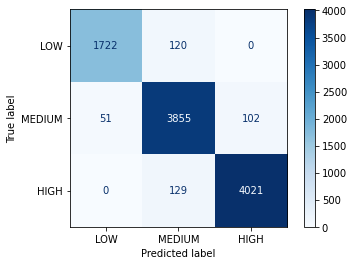

In [201]:
f = plot_confusion_matrix(knn, X_test_normalized, y_test, cmap='Blues', display_labels = LEVELS)  
plt.show()
f.figure_.savefig("knn_confusion.pdf", bbox_inches='tight')

In [202]:
print(classification_report(y_test, knn.predict(X_test_normalized), target_names=LEVELS))

              precision    recall  f1-score   support

         LOW       0.97      0.93      0.95      1842
      MEDIUM       0.94      0.96      0.95      4008
        HIGH       0.98      0.97      0.97      4150

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



# Multilayer Perceptron (MLP) using Backpropagation

In [203]:
from sklearn.neural_network import MLPClassifier

mlp_params={
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(5, 5)],
'solver': ["lbfgs", "sgd", "adam"],
'activation': ["logistic", "relu", "tanh"]
}

# Instanciate the Grid for parameter tuning
mlp_grid = GridSearchCV(MLPClassifier(), mlp_params, cv=5, scoring='accuracy', n_jobs=-1)

start = time.time()
mlp = mlp_grid.fit(X_train_normalized, y_train)
stop = time.time()
print(f"MLP Cross-Validation & Training time: {stop - start}s")

/usr/local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MLP Cross-Validation & Training time: 240.93812203407288s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [204]:
print(mlp.best_estimator_)
print(mlp.best_params_)
print('Best Accuracy: {0:.2%}'.format(mlp.best_score_))

MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 5))
{'activation': 'tanh', 'hidden_layer_sizes': (5, 5), 'learning_rate': 'constant', 'solver': 'adam'}
Best Accuracy: 99.27%


In [205]:
test = MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 5))

start = time.time()
test = test.fit(X_train_normalized, y_train)
stop = time.time()
print(f"MLP Training time: {stop - start}s")

MLP Training time: 10.777590036392212s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [206]:
accuracy = mlp.score(X_test_normalized, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 99.30%


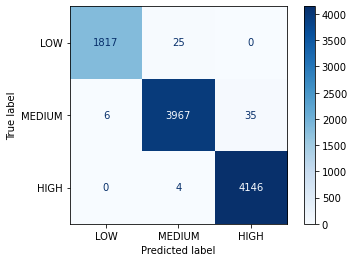

In [207]:
f = plot_confusion_matrix(mlp, X_test_normalized, y_test, cmap='Blues', display_labels = LEVELS)  
plt.show()
f.figure_.savefig("mlp_confusion.pdf", bbox_inches='tight')

In [208]:
print(classification_report(y_test, mlp.predict(X_test_normalized), target_names=LEVELS))

              precision    recall  f1-score   support

         LOW       1.00      0.99      0.99      1842
      MEDIUM       0.99      0.99      0.99      4008
        HIGH       0.99      1.00      1.00      4150

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Accuracy - Dataset size Plot

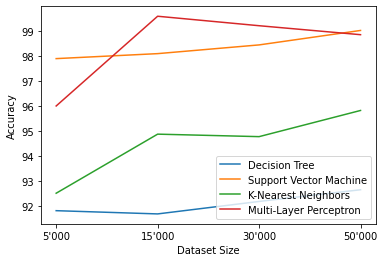

In [210]:
import matplotlib.pyplot as plt

dataset_sizes = ["5'000", "15'000", "30'000", "50'000"]
DT = [91.80, 91.67, 92.17, 92.64]
SVM = [97.90, 98.10, 98.45, 99.03]
KNN = [92.50, 94.87, 94.77, 95.82]
MLP = [96.00, 99.60, 99.22, 98.86]

plt.plot(dataset_sizes, DT, label = "Decision Tree")
plt.plot(dataset_sizes, SVM, label = "Support Vector Machine")
plt.plot(dataset_sizes, KNN, label = "K-Nearest Neighbors")
plt.plot(dataset_sizes, MLP, label = "Multi-Layer Perceptron")

plt.xlabel('Dataset Size')
plt.ylabel('Accuracy')
plt.legend()

plt.show()